In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:
full_path = 'data/2024-04-04_DVL1_test_data_for_refit.csv'
dvl1 = pd.read_csv(full_path, delimiter=',')
dvl1 = dvl1[dvl1['r_value'] != 0]

In [3]:
def map_steel_family(df):

    family_mapping = {
        # AHSS family
        '2F63': 'AHSS',
        '2F95': 'AHSS',
        '2Q91': 'AHSS',
        '3F63': 'AHSS',
        
        # CMn family
        '110E': 'CMn', '110F': 'CMn', '110H': 'CMn', '112H': 'CMn', 
        '112L': 'CMn', '114E': 'CMn', '116L': 'CMn', '125C': 'CMn',
        '126C': 'CMn', '126L': 'CMn', '180L': 'CMn', '180N': 'CMn',
        '184L': 'CMn', '184M': 'CMn', '186C': 'CMn', '187L': 'CMn',
        '180G': 'CMn', '111C': 'CMn', '114C': 'CMn', '114H': 'CMn',
        '121L': 'CMn', '1T46': 'CMn', '1T36': 'CMn', '1T86': 'CMn',
        '1S38': 'CMn', '1S42': 'CMn', '1T32': 'CMn', '1T80': 'CMn',
        '1T82': 'CMn', '1T34': 'CMn', '110B': 'CMn', '1P65': 'CMn',
        '184K': 'CMn', '1N47': 'CMn', '1N57': 'CMn', '123L': 'CMn',
        '115H': 'CMn', '1T44': 'CMn', '1T84': 'CMn', '1T94': 'CMn', 
        '115E': 'CMn', '1P85': 'CMn', 
        
        # HSLA family
        '1N80': 'HSLA', '1N31': 'HSLA', '1N60': 'HSLA', '1N61': 'HSLA',
        '1N81': 'HSLA', '1N91': 'HSLA', '1N84': 'HSLA', '1N64': 'HSLA',
        '1N94': 'HSLA', '1N32': 'HSLA', '1N33': 'HSLA', '1N62': 'HSLA',
        '1N63': 'HSLA', '1N82': 'HSLA', '1N83': 'HSLA', '1N92': 'HSLA',
        '1N93': 'HSLA', '1N36': 'HSLA', '1N37': 'HSLA', '1N66': 'HSLA',
        '1N67': 'HSLA', '1N86': 'HSLA', '1N87': 'HSLA', '1N96': 'HSLA',
        '1N97': 'HSLA', '1N38': 'HSLA', '1N39': 'HSLA', '1N68': 'HSLA',
        '1N69': 'HSLA', '1N88': 'HSLA', '1N98': 'HSLA', '1N99': 'HSLA',
        '3N73': 'HSLA', '3N73': 'HSLA',
        
        # IF family
        '514Z': 'IF', '515M': 'IF', '581G': 'IF', '590Q': 'IF',
        '590Z': 'IF', '591M': 'IF', '594Q': 'IF', '594Z': 'IF',
        '595M': 'IF', '542P': 'IF', '543P': 'IF', '544P': 'IF',
        '545P': 'IF', '540Z': 'IF', '541M': 'IF', '54AE': 'IF',
        '561P': 'IF', '592P': 'IF', '593P': 'IF', '598P': 'IF',
        '599P': 'IF', '59AD': 'IF', '552V': 'IF', '553V': 'IF',
        '589L': 'IF', '59TM': 'IF', '55AV': 'IF'
    }
    
    df_copy = df.copy()
    
    # Map steel family on the copy
    df_copy['steel_family'] = df_copy['steel_grade'].map(family_mapping)
    
    return df_copy

In [4]:
nan_cols = dvl1.isna().sum().sort_values(ascending=False)
nan_cols = nan_cols[nan_cols > 0] #columns with no nan are not relevant

dvl1.drop(columns=nan_cols.index[:15], inplace=True)
dvl1.dropna(inplace=True)

In [ ]:
path = 'data/MDC_Data_Descriptions_MeCoMeP-r-value.xlsx'
desc = pd.read_excel(path, sheet_name=3)

tmp = desc[(desc['model'] != 'n') & (desc['Table Name'] == 'mecomep_dv21') 
             & ((desc['Input Type'] == 'Actual - Measurement or Count') | (desc['Input Type'] == 'Prediction - Calculation'))]
features_selected = tmp[['Attribute Name', 'Input Type']]

existing_columns = [col for col in features_selected['Attribute Name'] if col in dvl1.columns]
dvl1_selected = dvl1[existing_columns+['r_value', 'steel_grade']]

corr_threshold = 0.2

corr = dvl1_selected.drop(['steel_grade'], axis=1).corr()['r_value'].abs()
selected_features = corr[abs(corr) >= corr_threshold].index.tolist()

print(f'dropped {len(dvl1_selected.columns) - len(selected_features)} columns')

dvl1_selected = dvl1_selected[selected_features+['steel_grade']]
counts = dvl1_selected['steel_grade'].value_counts()
filtered_values = counts[counts >= 5].index
dvl1_selected = dvl1_selected[dvl1_selected['steel_grade'].isin(filtered_values)]
dvl1_selected = map_steel_family(dvl1_selected).drop(['steel_grade'], axis=1)
dvl1_selected

dropped 26 columns


/opt/anaconda3/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


,cold_roll_reduction,elong_tl_pct,elong_tm_pct,gauge_f1,gauge_f2,gauge_f3,gauge_f4,gauge_f5,gauge_f6,gauge_f7,...,time_eq2_v,time_inter_f1,time_inter_f2,time_inter_f3,time_inter_f4,time_inter_f5,time_inter_f6,time_inter_f7,r_value,steel_family
0,73.24,1.0,13.0,27.672787,20.019131,14.791326,11.552423,8.339145,6.686268,5.60718,...,1.790847e-12,36.270,3.060,2.140,1.610,1.220,0.960,0.760,1.95,IF
1,66.97,2.0,16.0,24.529786,16.663215,11.979636,9.008755,6.573885,5.513293,4.56455,...,1.394742e-14,38.100,3.690,2.400,1.710,1.300,1.050,0.850,1.15,CMn
5,63.12,2.0,16.0,22.848893,14.682742,9.793226,7.885927,6.211950,4.874164,4.05114,...,1.177077e-12,39.810,4.720,2.840,1.990,1.480,1.210,1.000,1.00,HSLA
7,79.65,1.0,11.0,24.390000,15.290000,9.910000,7.150000,5.130000,3.950000,3.40328,...,4.473607e-12,62.787,2.689,1.661,1.058,0.742,0.545,0.407,1.95,IF
8,79.88,2.0,0.0,25.470000,15.350000,9.980000,7.050000,5.060000,3.940000,3.52231,...,7.637513e-13,80.229,2.621,1.746,1.112,0.806,0.583,0.455,1.80,IF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15717,78.13,1.0,15.0,26.590000,17.980000,12.760000,9.440000,7.160000,5.550000,3.80039,...,7.630784e-13,68.653,2.569,1.715,1.213,0.882,0.673,0.514,1.50,IF
15727,67.90,2.0,16.0,21.780000,15.370000,11.570000,8.530000,6.530000,5.390000,4.70435,...,2.428961e-12,54.578,4.312,2.843,2.068,1.521,1.159,0.939,0.95,HSLA
15730,80.32,1.0,15.0,27.028830,18.710170,12.928046,9.371886,7.225700,5.603521,4.39936,...,2.237163e-15,35.765,3.247,2.170,1.481,1.049,0.790,0.610,2.15,IF
15731,80.37,1.0,12.0,25.920000,17.000000,11.460000,7.940000,5.870000,4.500000,3.80944,...,5.574018e-15,67.778,2.514,1.633,1.102,0.769,0.562,0.434,1.90,IF


In [6]:
features = [col for col in dvl1_selected.columns if col not in ['r_value', 'steel_family']]
features_dict = {
   'time': [col for col in features if 'time' in col.lower()], 
   'chemical': ['pct_al', 'pct_b', 'pct_c', 'pct_cr', 'pct_mn', 'pct_n', 'pct_nb', 'pct_si', 'pct_ti', 'pct_v', 'mfia_coil_frac_fer', 'mfia_et1_frac_fer', 'mfia_et2_frac_fer'],
}
features_dict['process'] = [col for col in features if col not in features_dict['time'] and col not in features_dict['chemical']]

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
dvl1_scaled = scaler.fit_transform(dvl1_selected.drop(['steel_family'], axis=1))
dvl1_scaled_df = pd.DataFrame(dvl1_scaled, columns=dvl1_selected.drop(['steel_family'], axis=1).columns)
dvl1_scaled_df['steel_family'] = dvl1_selected['steel_family'].reset_index(drop=True)

In [8]:
features = [col for col in dvl1_selected.columns if col not in ['r_value', 'steel_family']]
features_dict = {
   'time': [col for col in features if 'time' in col.lower()], 
   'chemical': ['pct_al', 'pct_b', 'pct_c', 'pct_cr', 'pct_mn', 'pct_n', 'pct_nb', 'pct_si', 'pct_ti', 'pct_v', 'mfia_coil_frac_fer', 'mfia_et1_frac_fer', 'mfia_et2_frac_fer'],
}
features_dict['process'] = [col for col in features if col not in features_dict['time'] and col not in features_dict['chemical']]

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm

def optimize_hyperparameters(X_train, y_train):
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': [1.0, 'sqrt', 'log2']
    }
    grid_search = GridSearchCV(
        estimator=RandomForestRegressor(random_state=42),
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    return {
        'best_params': grid_search.best_params_,
        'best_estimator': grid_search.best_estimator_,
        'best_score': -grid_search.best_score_
    }

def train_optimized_family_models(df):
    optimized_models = {}
    families = list(df['steel_family'].unique())
    for family in tqdm(families, desc="Optimizing Models", unit="family"):
        family_data = df[df['steel_family'] == family]
        X = family_data.drop(['steel_family', 'r_value'], axis=1)
        y = family_data['r_value']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        optimization_results = optimize_hyperparameters(X_train, y_train)
        best_model = optimization_results['best_estimator']
        best_model.fit(X_train, y_train)
        
        y_pred_train = best_model.predict(X_train)
        y_pred_test = best_model.predict(X_test)
        
        optimized_models[family] = {
            'model': best_model,
            'best_params': optimization_results['best_params'],
            'best_score': optimization_results['best_score'],
            'train_mse': mean_squared_error(y_train, y_pred_train),
            'test_mse': mean_squared_error(y_test, y_pred_test),
            'train_r2': r2_score(y_train, y_pred_train),
            'test_r2': r2_score(y_test, y_pred_test)
        }
    return optimized_models

In [10]:
# Run optimization
optimized_family_models = train_optimized_family_models(dvl1_scaled_df)

for family, model_info in optimized_family_models.items():
    print(f"Family: {family}")
    print(f"Best Parameters: {model_info['best_params']}")
    print(f"Best CV Score (MSE): {model_info['best_score']}")
    print(f"Test MSE: {model_info['test_mse']}")
    print(f"Test R2: {model_info['test_r2']}")

Optimizing Models: 100%|██████████| 3/3 [01:22<00:00, 27.49s/family]

Family: IF
Best Parameters: {'max_depth': 5, 'max_features': 1.0, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best CV Score (MSE): 0.09891640819452649
Test MSE: 0.12143818600710236
Test R2: 0.46982056109742354
Family: CMn
Best Parameters: {'max_depth': 5, 'max_features': 1.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best CV Score (MSE): 0.053606116577882
Test MSE: 0.05024917389185809
Test R2: 0.6024166383888157
Family: HSLA
Best Parameters: {'max_depth': 5, 'max_features': 1.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best CV Score (MSE): 0.038737117365363234
Test MSE: 0.030300294247561397
Test R2: 0.6479515323318363


In [11]:
optimized_family_models

{'IF': {'model': RandomForestRegressor(max_depth=5, min_samples_leaf=2, min_samples_split=5,
                        n_estimators=200, random_state=42),
  'best_params': {'max_depth': 5,
   'max_features': 1.0,
   'min_samples_leaf': 2,
   'min_samples_split': 5,
   'n_estimators': 200},
  'best_score': 0.09891640819452649,
  'train_mse': 0.07859467513329386,
  'test_mse': 0.12143818600710236,
  'train_r2': 0.6061543485906122,
  'test_r2': 0.46982056109742354},
 'CMn': {'model': RandomForestRegressor(max_depth=5, min_samples_leaf=2, random_state=42),
  'best_params': {'max_depth': 5,
   'max_features': 1.0,
   'min_samples_leaf': 2,
   'min_samples_split': 2,
   'n_estimators': 100},
  'best_score': 0.053606116577882,
  'train_mse': 0.03564677647170701,
  'test_mse': 0.05024917389185809,
  'train_r2': 0.7373868354071225,
  'test_r2': 0.6024166383888157},
 'HSLA': {'model': RandomForestRegressor(max_depth=5, min_samples_leaf=2, n_estimators=200,
                        random_state=42),

In [12]:
def plot_predicted_vs_actual(optimized_models, df):
    plt.figure(figsize=(15, 5 * len(optimized_models)))
    
    for i, (family, model_info) in enumerate(optimized_models.items(), 1):
        plt.subplot(len(optimized_models), 1, i)
        
        # Recreate train/test split
        family_data = df[df['steel_family'] == family]
        X = family_data.drop(['steel_family', 'r_value'], axis=1)
        y = family_data['r_value']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Predict
        y_pred_test = model_info['model'].predict(X_test)
        
        # Plot
        plt.scatter(y_test, y_pred_test, alpha=0.7)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.title(f'{family} - Predicted vs Actual R-Value')
        plt.xlabel('Actual R-Value')
        plt.ylabel('Predicted R-Value')
        
        # Annotate with R² and MSE
        plt.text(0.05, 0.95, 
                 f"Test R²: {model_info['test_r2']:.4f}\n" +
                 f"Test MSE: {model_info['test_mse']:.4f}", 
                 transform=plt.gca().transAxes, 
                 verticalalignment='top')
    
    plt.tight_layout()
    plt.show()

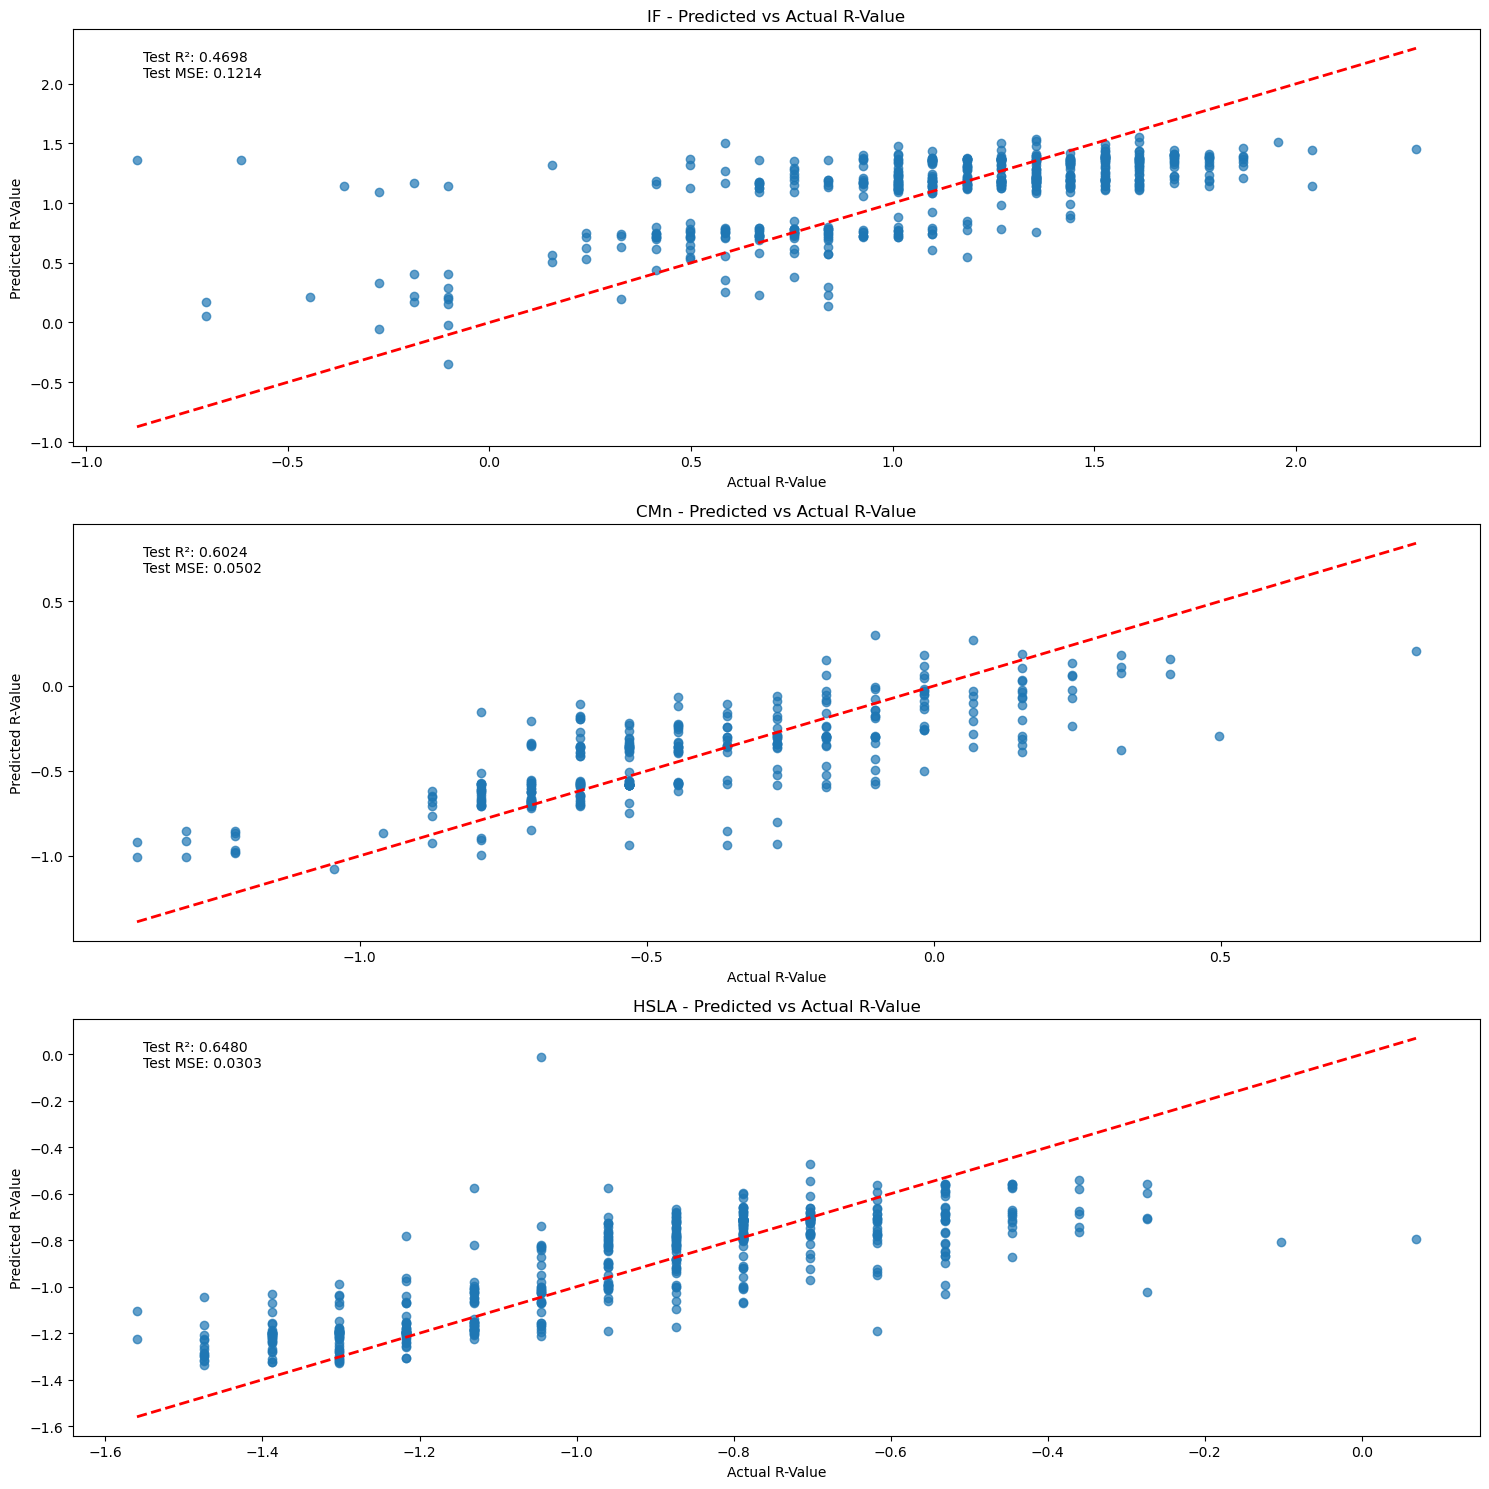

In [13]:
plot_predicted_vs_actual(optimized_family_models, dvl1_scaled_df)